In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from statsmodels.robust import mad

# Include the utils functions
import os
import sys
sys.path.insert(0, os.path.abspath('./'))
from utils import *

from astropy.stats import bayesian_blocks

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

In [2]:
# The sol with the deepest vortex, as reported by Spiga et al. (2020)
# sol = 65
sol = 323
LTST, LTST_and_sol, sol_data = retrieve_pressure_data(sol)

filename = "../Previous Studies/Data from Spiga et al. 2020/alldrop_ordered.txt"
Spigas_data = np.genfromtxt(filename, names=True, delimiter=";", dtype=None)
ind = Spigas_data["SOL"] == sol
Spigas_data_sol = Spigas_data[ind]

/Users/brian/Documents/research/Recovering-Martian-Dust-Devil-Population/code/utils.py:178: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)
/Users/brian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  import sys


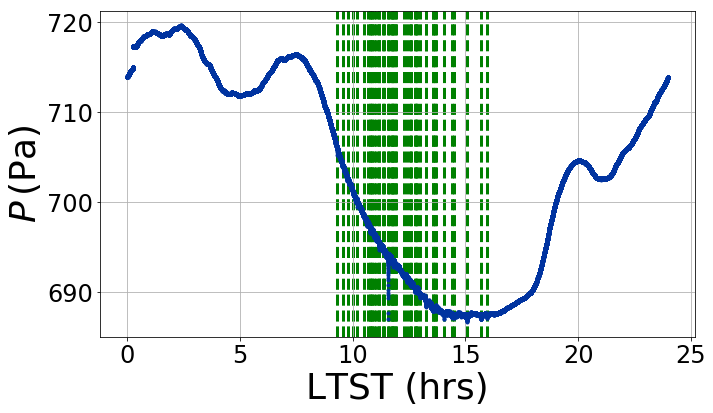

In [3]:
# dt = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
# edges = bayesian_blocks(LTST_and_sol, sol_data['PRESSURE'], fitness='measures')

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

ax.plot(LTST, sol_data['PRESSURE'], marker='.', ls='', color=BoiseState_blue)

for cur_vortex in Spigas_data_sol['_LTST_']:
    ax.axvline(cur_vortex, color='green', ls='--', lw=3, zorder=-1)

    ax.tick_params(labelsize=24)
ax.set_xlabel("LTST (hrs)", fontsize=36)
ax.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=36)
ax.grid(True)

(7760, 7770)

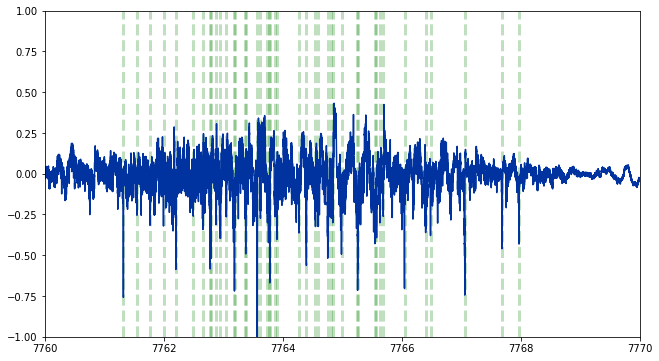

In [11]:
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
window_length = int((1000./3600)/delta_t)

# High-pass filter the pressure data
men = moving_average(sol_data['PRESSURE'], window_length, mode='same')
st = moving_std(sol_data['PRESSURE'], window_length, mode='same')
# filtered_pressure = (sol_data['PRESSURE'] - men)#/st
# print(np.median(st[(LTST_and_sol > 1569) & (LTST_and_sol < 1576)]))
# print(np.std(filtered_pressure[(LTST_and_sol > 1569) & (LTST_and_sol < 1576)]))
# print(mad(filtered_pressure[(LTST_and_sol > 1569) & (LTST_and_sol < 1576)]))

pressure_filter = savgol_filter(sol_data['PRESSURE'], window_length, 0, mode='nearest')
filtered_pressure = sol_data['PRESSURE'] - pressure_filter
# filtered_pressure /= mad(filtered_pressure)

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

# ax.plot(LTST_and_sol, st, color=BoiseState_blue)
ax.plot(LTST_and_sol, filtered_pressure, color=BoiseState_blue)
# ax.axhline(np.median(filtered_pressure) - 5.*mad(filtered_pressure))
# ax.axhline(np.median(filtered_pressure) + 5.*mad(filtered_pressure))

ax.axhline(-5.)
# ax.axhline(3.)

# ax.axhline(3.)

# edges = bayesian_blocks(LTST_and_sol, filtered_pressure, 3., fitness='measures', ncp_prior=3.)
# edges = bayesian_blocks(LTST_and_sol, filtered_pressure, mad(filtered_pressure), fitness='measures')

# for cur_edge in edges:# - 24.*sol:
#     ax.axvline(cur_edge, color=BoiseState_orange, zorder=-1)
    
for cur_vortex in Spigas_data_sol['_LTST_'] + 24.*sol:
    ax.axvline(cur_vortex, color='green', ls='--', lw=3, zorder=-1, alpha=0.25)

# ax.set_ylim([0, 1])
# ax.set_ylim([0, 0.1])
    
ax.set_ylim([-1, 1])
# ax.set_xlim([1569, 1576])
ax.set_xlim([7760, 7770])
# ax.set_xlim([1571.5, 1572.5])
# ax.set_xlim([1574.6, 1574.8])
# ax.set_xlim([9.5, 16])
# ax.set_ylim([-10, 10])

(317,)


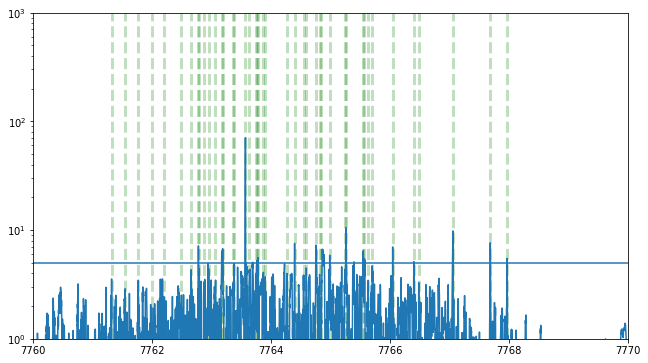

In [13]:
# Convolve with Lorentzian
delta_t = np.max(LTST_and_sol[1:] - LTST_and_sol[0:-1])
window_length = int((1000./3600)/delta_t)

depth = 1. # Pa
width = 5.*delta_t # seconds
lorentzian_time = np.arange(-3.*width, 3.*width, delta_t)
lorentzian = modified_lorentzian(lorentzian_time, 0., 0., 0., depth, width)
lorentzian /= np.abs(np.min(lorentzian))

# High-pass filter the pressure data
men = moving_average(sol_data['PRESSURE'], window_length, mode='same')
st = moving_std(sol_data['PRESSURE'], window_length, mode='same')
filtered_pressure = (sol_data['PRESSURE'] - men)#/st

fig = plt.figure(figsize=(6*aspect_ratio, 6))
ax = fig.add_subplot(111)

convolution = np.convolve(filtered_pressure, lorentzian, mode='same')
convolution -= np.median(convolution)
convolution /= mad(convolution)
# ax.plot(LTST_and_sol, filtered_pressure)
ax.semilogy(LTST_and_sol, np.abs(convolution))

ax.set_xlim([7760, 7770])
ax.set_ylim([1, 1000])

# ax.plot(LTST_and_sol, st, color=BoiseState_blue)
    
# Retreive convolution values    
convolve_values = np.zeros_like(Spigas_data_sol['_LTST_'])
for i in range(len(Spigas_data_sol['_LTST_'])):
    ax.axvline(Spigas_data_sol['_LTST_'][i] + 24.*sol, color='green', ls='--', lw=3, zorder=-1, alpha=0.25)
    convolve_values[i] = convolution[np.argmin(np.abs(Spigas_data_sol['_LTST_'][i] + 24.*sol - LTST_and_sol))]
    
ax.axhline(5.)

print(convolution[convolution > 5].shape)

(1650,)


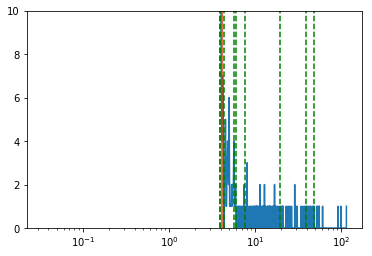

In [79]:
ind = (LTST_and_sol > 1569) & (LTST_and_sol < 1576)

hst, bin_edges = np.histogram(np.abs(convolution[ind]), bins='auto')
bins = 0.5*(bin_edges[1:] + bin_edges[0:-1])

plt.semilogx(bins, hst)
med = np.median(np.abs(convolution[ind]))
md = mad(np.abs(convolution[ind]))

plt.axvline(med + 5.*md, color=BoiseState_orange)
plt.axvline(med - 5.*md, color=BoiseState_orange)

for val in convolve_values:
    plt.axvline(val, color='green', ls='--')
    
# plt.xlim([3, 100])
plt.ylim([0, 10])

print(hst[bins > med + 5.*md].shape)